In [4]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
TRAIN_FILE_NAME = ".\\OFT_model\\OFT_train_dict_old_features_hand_picked.pkl"
VALIDATION_FILE_NAME = ".\\OFT_model\\OFT_validation_dict_old_features_hand_picked.pkl"
TEST_FILE_NAME = ".\\OFT_model\\OFT_test_dict_old_features_hand_picked.pkl"
UMC_PATH = ".\\Universal-Mouse-Code\\"

EPM_TRAIN_FILE = ".\\EPM_model\\EPM_train_dict_May_17.pkl"
EPM_VAL_FILE = ".\\EPM_model\\EPM_val_dict_May_17.pkl"
OFT_TRAIN_FILE_NAME = ".\\OFT_model\\OFT_train_dict_old_features_hand_picked.pkl"
OFT_VAL_FILE_NAME = ".\\OFT_model\\OFT_validation_dict_old_features_hand_picked.pkl"
FLX_TRAIN_FILE = ".\\FLX_model\\FLX_train_dict_old_features.pkl"
FLX_VAL_FILE = ".\\FLX_model\\FLX_validation_dict_old_features.pkl"

FEATURE_VECTOR = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
FEATURE_WEIGHT = [10,1,1]
sys.path.append(UMC_PATH)
#from dCSFA_model import dCSFA_model
import umc_data_tools as umc_dt
from dCSFA_NMF import dCSFA_NMF

if torch.cuda.is_available():
    device="cuda:0"
else:
    device="cpu"


print("Using device: %s"%(device))

Using device: cuda:0


In [5]:
with open(TRAIN_FILE_NAME,'rb') as f:
    train_dict = pickle.load(f)

with open(VALIDATION_FILE_NAME,'rb') as f:
    val_dict = pickle.load(f)

NUM_FREQS = 56
FEATURE_LIST = ['X_power_1_2','X_coh_1_2','X_gc_1_2']

running_idx = 0
feature_groups = []
for idx,feature in enumerate(FEATURE_VECTOR):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end


NUM_FEATURES = np.hstack([train_dict[feature] for feature in FEATURE_VECTOR]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])#*scale_vector
y_hc_train = train_dict['y_Homecage'].astype(bool)
y_task_train = ~y_hc_train
y_ROI_train = train_dict['y_ROI']
y_vel_train = train_dict['y_vel']
y_mouse_train = train_dict['y_mouse']
y_time_train = train_dict['y_time']

#Validation Arrays
X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])#*scale_vector
y_hc_val = val_dict['y_Homecage'].astype(bool)
y_task_val = ~y_hc_val
y_ROI_val = val_dict['y_ROI']
y_vel_val = val_dict['y_vel']
y_mouse_val = val_dict['y_mouse']
y_time_val = val_dict['y_time']

intercept_mask = OneHotEncoder().fit_transform(y_mouse_train.reshape(-1,1)).todense()

In [7]:
N_COMPONENTS=20
MOMENTUM_MODEL = ".\\{}_OFT_10_res_loss_10_power_features.pt"
TRAIN = False
NETWORK_CONSTRAINT="Positive"
DIM_IN = X_train.shape[1]
'''model = dCSFA_NMF(n_components=N_COMPONENTS,dim_in=DIM_IN,device='auto',n_intercepts=intercept_mask.shape[1],
                n_sup_networks=1,optim_name='AdamW',recon_loss='MSE',sup_recon_weight=1,sup_weight=1,
                useDeepEnc=True,h=256,sup_recon_type="Residual",feature_groups=feature_groups,fixed_corr="negative")
model.fit(X_train,y_task_train,intercept_mask=intercept_mask,batch_size=128,lr=1e-3,
        n_pre_epochs=100,n_epochs=1500,verbose=True,pretrain=True,best_model_name="Negative_OFT_Network_March_25_state_dict.pt")
torch.save(model,"Negative_OFT_Network_HC_vs_Task_March_25.pt")'''

if TRAIN:
        model = dCSFA_NMF(n_components=N_COMPONENTS,dim_in=DIM_IN,device='auto',n_intercepts=intercept_mask.shape[1],
                        n_sup_networks=1,optim_name='SGD',recon_loss='MSE',sup_recon_weight=1,sup_weight=1,
                        useDeepEnc=True,h=256,sup_recon_type="Residual",feature_groups=feature_groups,fixed_corr=NETWORK_CONSTRAINT)
        model.fit(X_train,y_task_train,intercept_mask=intercept_mask,batch_size=128,lr=1e-3,
                n_pre_epochs=100,n_epochs=2000,verbose=True,pretrain=True,best_model_name="{}_OFT_SGD_Network_July_23_state_dict.pt".format(NETWORK_CONSTRAINT),
                momentum=0.9)
        torch.save(model,MOMENTUM_MODEL.format(NETWORK_CONSTRAINT))
else:
        model = torch.load(MOMENTUM_MODEL.format(NETWORK_CONSTRAINT),map_location="cpu")
        model.device = "cpu"
        model.Encoder.eval()
#model = torch.load(".\\Results-May-12\\{}_OFT_Network_HC_vs_Task_March_25.pt".format(NETWORK_CONSTRAINT),map_location='cpu')
#model.device='cpu'

In [ ]:
def getReconContribution(X,n_components,model):
    perc_contribution_list = []
    EPSILON = 1e-6
    X_recon,_,_,s = model.transform(X)
    for component in range(n_components):
        X_recon_comp = model.get_comp_recon(s,component)
        perc_contribution = np.divide(X_recon_comp+EPSILON,X_recon+EPSILON)
        avg_perc_contribution = np.mean(perc_contribution,axis=0)

        perc_contribution_list.append(avg_perc_contribution)
    
    perc_contribution_mat = np.vstack(perc_contribution_list)
    return perc_contribution_mat


perc_contribution_train = getReconContribution(X_train,20,model)
perc_contribution_val = getReconContribution(X_val,20,model)
positive_mask = y_task_val==1
perc_contribution_positive_labels = getReconContribution(X_val[positive_mask==1],20,model)
perc_contribution_negative_labels = getReconContribution(X_val[positive_mask==0],20,model)
experiment = "OFT"
np.savetxt("{}_train_network_perc_contribution.csv".format(experiment),perc_contribution_train)
np.savetxt("{}_val_network_perc_contribution.csv".format(experiment),perc_contribution_val)
np.savetxt("{}_val_network_perc_contribution_positive_labels.csv".format(experiment),perc_contribution_positive_labels)
np.savetxt("{}_val_network_perc_contribution_negative_labels.csv".format(experiment),perc_contribution_negative_labels)

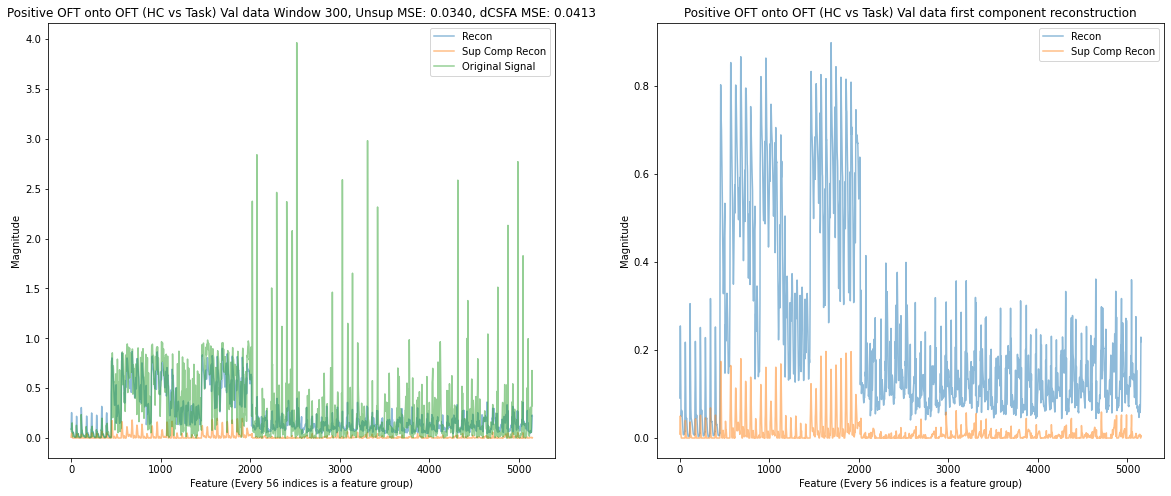

In [13]:
umc_dt.make_recon_plots(model,X_val,300,task="Positive OFT onto OFT (HC vs Task) Val",saveFile="OFT_Boosted_Power.png")

In [14]:
y_pred, s = model.predict(X_train,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,y_task_train,y_mouse_train)
print("train roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,y_task_train,y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))
y_pred, s = model.predict(X_val,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,y_task_val,y_mouse_val)
print("val roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,y_task_val,y_mouse_val,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))


train roc auc mean: 0.99 +/- 0.00
Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
train mw auc mean: 1.00 +/- 0.00
val roc auc mean: 0.74 +/- 0.07
val mw auc mean: 0.85 +/- 0.07


c:\Users\micha\Anaconda3\envs\cpne\lib\site-packages\sklearn\metrics\_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\micha\Anaconda3\envs\cpne\lib\site-packages\sklearn\metrics\_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\micha\Anaconda3\envs\cpne\lib\site-packages\sklearn\metrics\_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\micha\Anaconda3\envs\cpne\lib\site-packages\sklearn\metrics\_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [ ]:
y_pred, s = model.predict(X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,y_task_train,y_mouse_train)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,y_task_train,y_mouse_train,s,True)
print("Training MW AUCs: ",mw_auc_dict)

df = umc_dt.make_projection_csv(OFT_TRAIN_FILE_NAME,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = ".\\PosNeg_Results\\{}_OFT_HC_vs_Task_Train_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)

y_pred, s = model.predict(X_val,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,y_task_val,y_mouse_val)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,y_task_val,y_mouse_val,s,True)
print("Training MW AUCs: ",mw_auc_dict)

df = umc_dt.make_projection_csv(OFT_VAL_FILE_NAME,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = ".\\PosNeg_Results\\{}_OFT_HC_vs_Task_Val_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)


C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Training ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse04191': 0.9925742574257426, 'Mouse04201': 0.9822695035460992, 'Mouse04202': 1.0, 'Mouse04205': 0.998442367601246, 'Mouse04215': nan, 'Mouse3191': 0.9834983498349835, 'Mouse3192': nan, 'Mouse3193': 0.9924528301886792, 'Mouse3194': nan, 'Mouse3203': nan, 'Mouse39114': 0.9500000000000001, 'Mouse39124': 0.9783950617283951, 'Mouse39133': 0.9797047970479704, 'Mouse69064': 0.9902597402597403, 'Mouse69072': 0.9449838187702265, 'Mouse69074': 0.946524064171123}
Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
Training MW AUCs:  {'auc_method': 'mannWhit

In [ ]:
y_pred, s = model.predict(X_train,include_scores=True)
#roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,y_task_train,y_mouse_train)
#print("train roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,y_task_train,y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))


y_pred, s = model.predict(X_val,include_scores=True)
#roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,y_task_val,y_mouse_val)
#print("val roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,y_task_val,y_mouse_val,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))
#umc_dt.make_recon_plots(model,X_train,0,task="OFT (HC vs Task) Training",saveFile="oft_train_recon.png")
#umc_dt.make_recon_plots(model,X_val,0,task="OFT (HC vs Task) Val",saveFile="oft_val_recon.png")

Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
train mw auc mean: 1.00 +/- 0.00
val mw auc mean: 0.84 +/- 0.06


### FLX Projections

In [ ]:
with open(FLX_TRAIN_FILE,"rb") as f:
    flx_train_dict = pickle.load(f)

with open(FLX_VAL_FILE,"rb") as f:
    flx_validation_dict = pickle.load(f)

FULL_FEATURE_LIST = ["X_power_1_2_full","X_coh_1_2_full","X_gc_1_2_full"]

flx_X_train = np.hstack([flx_train_dict[feature] for feature in FEATURE_VECTOR])
flx_y_train = flx_train_dict['y_flx']
flx_y_mouse_train = flx_train_dict['y_mouse']
flx_y_expDate_train = flx_train_dict['y_expDate']
flx_y_time_train = flx_train_dict['y_time']

flx_X_validation = np.hstack([flx_validation_dict[feature] for feature in FEATURE_VECTOR])
flx_y_validation = flx_validation_dict['y_flx']
flx_y_mouse_validation = flx_validation_dict['y_mouse']
flx_y_expDate_validation = flx_validation_dict['y_expDate']
flx_y_time_validation = flx_validation_dict['y_time']

flx_X = np.vstack([flx_X_train,flx_X_validation])
flx_y_task = np.hstack([flx_y_train,flx_y_validation])
flx_y_mouse = np.hstack([flx_y_mouse_train,flx_y_mouse_validation])
flx_y_expDate = np.hstack([flx_y_expDate_train,flx_y_expDate_validation])
flx_y_time = np.hstack([flx_y_time_train,flx_y_time_validation])

y_pred, s = model.predict(flx_X,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_task,flx_y_mouse)
print("ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_task,flx_y_mouse,s,True)
print("MW AUCs: ",mw_auc_dict)

df = umc_dt.make_projection_csv(FLX_TRAIN_FILE,model,FULL_FEATURE_LIST,
                    ['y_mouse_full','y_expDate_full','y_time_full','y_flx_full'],
                    save_file = ".\\PosNeg_Results\\{}_OFT_onto_FLX_flx_vs_saline_Train_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict,mousevar="y_mouse_full")

df = umc_dt.make_projection_csv(FLX_VAL_FILE,model,FULL_FEATURE_LIST,
                    ['y_mouse_full','y_expDate_full','y_time_full','y_flx_full'],
                    save_file = ".\\PosNeg_Results\\{}_OFT_onto_FLX_flx_vs_saline_Val_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict,mousevar="y_mouse_full")

C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse3191': 0.5482705964299109, 'Mouse3192': 0.5500245170148084, 'Mouse3193': 0.4785670288727543, 'Mouse3194': 0.4531576591811102, 'Mouse3202': nan, 'Mouse3203': 0.43069142118720205, 'Mouse99003': nan}
Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  1504
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  1874
n_negative samples  0
MW AUCs:  {'auc_method': 'mannWhitneyU', 'Mouse3191': (0.4550375385144393, 2.2940345863277457e-06), 'Mouse3192': (0.3134272028537805, 2.5961136541080813e-83), 'Mouse3193': (0.5265228246249448, 0.0057712241559287215), 'Mouse3194': (0.5684174925636408, 7.655611414079066e-13), 'Mouse3203': (0.5984695298837792, 1.7607890887699856e-24)}


In [ ]:
y_pred, s = model.predict(flx_X,include_scores=True)
#roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,oft_y_task,oft_y_mouse)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,flx_y_task,flx_y_mouse,s,True)
#print("EPM->FLX roc-auc: {} +/- {}".format(roc_mean,roc_std))
print("EPM->FLX mw-auc: {:0.2f} +/- {:0.2f}".format(mw_mean,mw_std))
#umc_dt.make_recon_plots(model,flx_X,0,task="OFT onto FLX (FLX vs Saline) Train and Val",saveFile="oft_onto_flx_recon.png")

Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  1504
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  1874
n_negative samples  0
EPM->FLX mw-auc: 0.48 +/- 0.06


## EPM Projections

In [ ]:
with open(EPM_TRAIN_FILE,"rb") as f:
    epm_train_dict = pickle.load(f)

with open(EPM_VAL_FILE,"rb") as f:
    epm_validation_dict = pickle.load(f)
#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict["X_power_1_2"],
                    epm_train_dict["X_coh_1_2"],
                    epm_train_dict["X_gc_1_2"]])#*SCALE_VECTOR

y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]

X_val = np.hstack([epm_validation_dict["X_power_1_2"],
                    epm_validation_dict["X_coh_1_2"],
                    epm_validation_dict["X_gc_1_2"]])#*SCALE_VECTOR

y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

epm_X = np.vstack([X_train,X_val])
epm_y_task = np.hstack([y_in_task_mask_train,y_in_task_mask_val])
epm_y_mouse = np.hstack([y_mouse_train,y_mouse_val])
epm_y_time = np.hstack([y_time_train,y_time_val])

y_pred, s = model.predict(epm_X,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,epm_y_task,epm_y_mouse)
print("ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,epm_y_task,epm_y_mouse,s,True)
print("MW AUCs: ",mw_auc_dict)

df = umc_dt.make_projection_csv(EPM_TRAIN_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel','y_locx','y_locy'],
                    save_file = ".\\PosNeg_Results\\{}_OFT_onto_EPM_HC_vs_Task_Train_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)

df = umc_dt.make_projection_csv(EPM_VAL_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel','y_locx','y_locy'],
                    save_file = ".\\PosNeg_Results\\{}_OFT_onto_EPM_HC_vs_Task_Val_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)

ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse04193': 0.540074289441392, 'Mouse04201': 0.6661390594606964, 'Mouse04202': 0.7206254006043402, 'Mouse04205': 0.5666666666666667, 'Mouse04215': 0.5487736273627363, 'Mouse0630': 0.4791764448199255, 'Mouse0633': 0.5637282888643601, 'Mouse0634': 0.5589002995293111, 'Mouse0642': 0.5721587649298493, 'Mouse0643': 0.5621301775147929, 'Mouse1551': 0.5280506480409367, 'Mouse39114': 0.6317987567987567, 'Mouse39124': 0.6505296048106589, 'Mouse39125': 0.5998198493285294, 'Mouse39133': 0.7113968605027512, 'Mouse6291': 0.5210053129813267, 'Mouse6292': 0.5115220038561715, 'Mouse6293': 0.532168458781362, 'Mouse69064': 0.6387724952994897, 'Mouse69065': 0.6978847435043305, 'Mouse69074': 0.6353210042969079, 'Mouse8580': 0.4977575007732756, 'Mouse8581': 0.5100498866213151, 'Mouse8582': 0.5297619047619048, 'Mouse8891': 0.5017788474115155, 'Mouse8894': 0.5803670745272526}
MW AUCs:  {'auc_method': 'mannWhitneyU', 'Mouse04193': (0.3245188321522934, 9.687909320

In [ ]:
y_pred, s = model.predict(epm_X,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,epm_y_task,epm_y_mouse)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,epm_y_task,epm_y_mouse,s,True)
print("OFT->EPM roc-auc: {} +/- {}".format(roc_mean,roc_std))
print("OFT->EPM mw-auc: {:0.2f} +/- {:0.2f}".format(mw_mean,mw_std))
#umc_dt.make_recon_plots(model,flx_X,0,task="OFT onto EPM (HC vs Task) Train and Val",saveFile="oft_onto_epm_recon.png")

OFT->EPM roc-auc: 0.5790906912111752 +/- 0.013607665694028551
OFT->EPM mw-auc: 0.34 +/- 0.02
